# Algorithm Performance Assessment

We compare the outcome of the prototype Level-2 SIC algorithm against ground-truth from the the Test Cards. The main comparison is against the so-called "Polar Scene 1" prepared by the ESA CIMR SCEPS study.

## L1 E2ES Demonstration Reference Scenario (Picasso) scene definition

At this stage, we base our performance assessment on the more realistic "Polar Scene 1" prepared by the ESA CIMR SCEPS study. The scene represents a typical winter polar case in the area around Svalbard and the Barents Sea. Interestingly, the true field of SIC (to be retrieved by the L2 prototype algorithm) is from the AMSR2 ASI SIC product run at the University of Bremen. This brings higher spatial resolution than if the SIC was taken from, e.g. a forecast model.

The geophysical parameters are first processed through the SCEPS forward simulator to generate Top-of-Atmosphere (TOA) brightness temperatures at all microwave channels, and second through the SCEPS instrument simulator to prepare a simulated L1B file. The input data and various parts of the simulator are documented in SCEPS reports.

In this notebook, we use the scene created 28-Jun-2023.

## Algorithm Performance Metrics (MPEF)

For SIC, the two metrics are:
* the bias (arithmetic average of the errors);
* the RMSE (standard deviation of the errors);

## Algorithm Calibration Data Set (ACDAT)

The L2 SIC algorithm was tuned against the ESA CCI Sea Ice Concentration Round-Robin Data Package (RRDP),
more specifically the `SIC0` and `SIC1` datasets representing respectively typical signatures for 0% SIC (Open Water) and 100% SIC (Consolidated Ice). 

The RRDP includes AMSR2 L1R Brightness Temperatures. This means that the prototype L2 SIC algorithm is currently tuned against actual AMSR2 TBs, not against the simulated TBs as found in the Test Card. Because the SIC retrieval is mostly linear, the difference in calibration of the algorithm might result in biases, but the RMSE should not be affected by this.

## Algorithm Validation Data Set (AVDAT)

The L2 SIC algorithm can be validated against a subset of the same RRDP that is not used in the training.


## Test Results using Demonstration Reference Scenario

In the following, we compare the result of the prototype L2 SIC algorithm (as stored in a L2 netCDF product file produced in the previous sections of this ATBD) against the ground truth from the SCEPS Polar Scene 1. The comparison is made in various ways to better understand the observed differences.

In [1]:
import xarray as xr
import numpy as np

import pyresample as pr

from matplotlib import pylab as plt
import cmocean

from sirrdp import rrdp_file
from pmr_sic import tiepoints as tp

input_test_card = 'sceps_polar_1'

In [2]:
# read the SIC from the L2 netCDF file:
l2_n = '/home/thomasl/Downloads/cimr_devalgo_l2_sic_ease2-1.0km-testcard_sceps-polar1.nc'
ds = xr.open_dataset(l2_n)
l2_sic = ds['ice_conc'][0,:].data

adef,_ = pr.utils.load_cf_area(l2_n, )
cart_crs = adef.to_cartopy_crs()

/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


### Compare L2 SIC to the "ground-truth" SICs

Access the ground truth SIC from the Test Card and compare pixel-by-pixel to the SIC retrieved by the algorithm.

In [3]:
owci_flg_cice = 2
owci_flg_ow   = 1

tc_tbs = dict()
if input_test_card == 'sceps_polar_1':
    # load SIC truth from the GEO file
    geo_file = '/home/thomasl/Documents/DEVALGO/From_SCEPS_Aug2023/Ref_scen_GEO_TDS/SCEPS/Cards/SCEPS_Geo_Polar_Scene_1/cimr_sceps_geo_card_polarscene_1_20161217_v1p0_part1.nc'
    tc_ds = xr.open_dataset(geo_file)
    tc_sic = tc_ds['asi_sea_ice_concentration_nh'][0,:,:].to_masked_array().transpose()
    
    # load TOA Tbs from the TOA file
    toa_file = '/home/thomasl/Documents/DEVALGO/From_SCEPS_Aug2023/Ref_scen_TOA_TDS/SCEPS/SCEPS_TOA_Geo_Polar_Scene_1/cimr_sceps_toa_card_polarscene_1_20161217_v1p0_aa_000.nc'
    tc_l1b = xr.open_dataset(toa_file)
    toa_band_name = 'toa_tbs_{b:}_{p:}po'
    
    tc_tbs['tb06v'] = np.rot90(tc_l1b[toa_band_name.format(b='C', p='V')].isel(time=0).sel(incidence_angle=55),-1)
    tc_tbs['tb19v'] = np.rot90(tc_l1b[toa_band_name.format(b='Ku', p='V')].isel(time=0).sel(incidence_angle=55),-1)
    tc_tbs['tb37v'] = np.rot90(tc_l1b[toa_band_name.format(b='Ka', p='V')].isel(time=0).sel(incidence_angle=55),-1)
    tc_tbs['tb37h'] = np.rot90(tc_l1b[toa_band_name.format(b='Ka', p='H')].isel(time=0).sel(incidence_angle=55),-1)
    tc_owci = np.zeros_like(tc_tbs['tb06v']).astype('int')
    tc_owci[-500:-20,20:500] = owci_flg_cice
    tc_owci[20:500,-500:-20] = owci_flg_ow
    
    # how many pixels to mask around the test card
    margin = 3
    
else:
    tc_fn = os.path.join(tc_path, tc_fn)
    tc_l1b = xr.open_dataset(tc_fn,)
    tc_surf = tc_l1b['surfaces'].data
    
    # how many pixels to mask around the test card
    margin = 15
    
    # use the surfaces variable to find where is ice and water
    tc_ice_mask = (tc_surf == 1)+(tc_surf == 2)
    tc_ocean_mask = (tc_surf == 5)+(tc_surf == 6)+(tc_surf == 7)+(tc_surf == 8)
    tc_oceanice_mask = tc_ice_mask + tc_ocean_mask
        
    tc_sic = np.ma.array(np.zeros_like(tc_surf))
    tc_sic[tc_ice_mask] = 100.
    tc_sic[~tc_oceanice_mask] = np.ma.masked
    
    # load TOA Tbs
    toa_band_name = '{b:}_band_{p:}'
    
    tc_tbs['tb06v'] = tc_l1b[toa_band_name.format(b='C', p='V')].to_masked_array()
    tc_tbs['tb19v'] = tc_l1b[toa_band_name.format(b='Ku', p='V')].to_masked_array()
    tc_tbs['tb37v'] = tc_l1b[toa_band_name.format(b='Ka', p='V')].to_masked_array()
    tc_tbs['tb37h'] = tc_l1b[toa_band_name.format(b='Ka', p='V')].to_masked_array()
    print(tc_tbs['tb06v'].shape, tc_tbs['tb06v'].min(), tc_tbs['tb06v'].max())
    
    tc_owci = np.zeros_like(tc_tbs['tb06v']).astype('int')
    tc_owci[tc_sic==1] = owci_flg_cice
    tc_owci[tc_sic==0] = owci_flg_ow
    
    if input_test_card == 'radiometric':    
        # Remove the top-most and right-most areas of the Radiometric TestCard
        #   Because we focus on the cells for the time being.
        _margin = 200
        tc_geom = np.ones_like(tc_surf).astype('bool')
        tc_geom[:,:_margin] = False
        tc_geom[-_margin:,:] = False
        tc_sic[~tc_geom] = np.ma.masked
        for ch in tc_tbs.keys():
            tc_tbs[ch][~tc_geom] = np.ma.masked
    

# Remove the border of the TestCard (because of the spill-over from the 0K from outside the scene):
tc_border = np.ones_like(tc_sic).astype('bool')
tc_border[-margin:,:] = False
tc_border[:margin,:] = False
tc_border[:,-margin:] = False
tc_border[:,:margin] = False
tc_sic[~tc_border] = np.ma.masked
for ch in tc_tbs.keys():
    tc_tbs[ch][~tc_border] = np.ma.masked

First compare as maps and maps of differences.

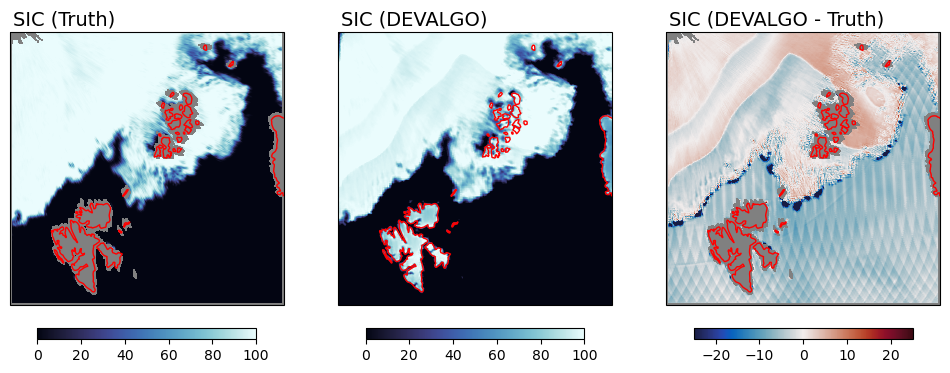

In [4]:
cmap_sic = cmocean.cm.ice
cmap_sic.set_bad('grey')
vmin = 0
vmax = 100

cmap_dif = cmocean.cm.balance
cmap_dif.set_bad('grey')
dmin = -25
dmax = -dmin

sic_diff = l2_sic - tc_sic

# visualize / plot
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,6), subplot_kw=dict(projection=cart_crs))
# first col : SIC truth
c = ax[0].imshow(tc_sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_sic,vmin=vmin,vmax=vmax)
ax[0].coastlines(color='red')
ax[0].text(0.01,1.01,'SIC (Truth)',va='bottom',fontsize=14,transform=ax[0].transAxes)
plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)
# second col : SIC algorithm
c = ax[1].imshow(l2_sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_sic,vmin=vmin,vmax=vmax)
ax[1].coastlines(color='red')
ax[1].text(0.01,1.01,'SIC (DEVALGO)',va='bottom',fontsize=14,transform=ax[1].transAxes)
plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)
# third col : SIC diff
c = ax[2].imshow(sic_diff, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_dif,vmin=dmin,vmax=dmax)
ax[2].coastlines(color='red')
ax[2].text(0.01,1.01,'SIC (DEVALGO - Truth)',va='bottom',fontsize=14,transform=ax[2].transAxes)
plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)
plt.show()


Then compare as histogram of differences, with BIAS and RMSE.

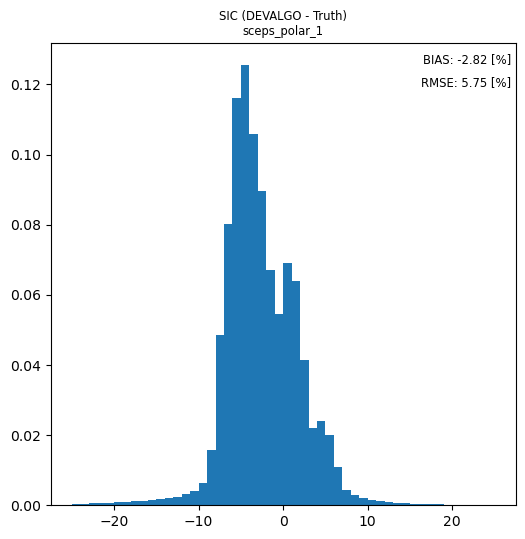

In [5]:
sic_diff_1d = sic_diff.compressed()
fig, ax = plt.subplots(figsize=(6,6))
hist_range = (dmin, dmax)
ax.hist(sic_diff_1d, bins=50, range=hist_range, density=True)
ax.set_title("SIC (DEVALGO - Truth)\n{}".format(input_test_card), fontsize='small')
ax.text(0.99,0.98, 'BIAS: {:.2f} [%]'.format(sic_diff_1d.mean()),
        transform=ax.transAxes, ha='right', va='top', fontsize='small')
ax.text(0.99,0.93, 'RMSE: {:.2f} [%]'.format(sic_diff_1d.std()),
        transform=ax.transAxes, ha='right', va='top', fontsize='small')
plt.show()

### Explore differences in brightness temperature space

The differences in True SIC can stem from the difference in calibration between the forward model used to prepare the TestCards and the SIC0 and SIC1 datasets used to tune the SIC algorithms. We explore this below by plotting the simulated TBs in a classic brightness temperature diagram.

In [6]:
def plot_2d_tiepoints(cice,ow,chx,chy,ax=None,leg=False,title=True,samples=('ow','cice')):
    
    if ax is None:
        fig = plt.figure(figsize=(10.,10.))
        ax = fig.add_subplot(111,aspect=1)
    
    try:
        ow_x = getattr(ow,chx)
        ow_y = getattr(ow,chy)
        ci_x = getattr(cice,chx)
        ci_y = getattr(cice,chy)
    except AttributeError as ae:
        raise ValueError('{} is not in {}'.format(ae,ow.channels))
    
    ichx = ow.channels.index(chx)
    ichy = ow.channels.index(chy)
    
    # plot the scatter
    if 'ow' in samples:
        ax.scatter(ow_x, ow_y, marker='d', color='dodgerblue', s=10, label='{} OW'.format(ow.source.upper()))
    if 'cice' in samples:
        ax.scatter(ci_x, ci_y, marker='s', color='gray', s=10, label='{} CICE'.format(cice.source.upper()))
    
    # place the tie-point signatures
    s = 200
    
    # draw ice line
    ax.plot([cice.myi_tp[ichx],cice.fyi_tp[ichx]],[cice.myi_tp[ichy],cice.fyi_tp[ichy]],'r-',lw=2)
    
    # label
    ax.set_xlabel(chx + ' [K]')
    ax.set_ylabel(chy + ' [K]')
    
    if title:
        ax.set_title('{} {}'.format(ow.source.upper(), ow.area))
    
    if leg:
        ax.legend()
    
    return ax

The maps below show selected brigthness temperature channels from the SCEPS `TOA` files. They generally show TBs in the expected range, but also some patterns that clearly translate into noticeable differences in the SIC field (e.g. bands over high-concentration sea ice). Other patterns observed in the SIC difference (e.g. the stripes over Open Water) are not present in the SCEPS TOA TB maps, indicating that they are either an artifact of the the L2 algorithm or added by the satellite simulator (feed-dependent OZA).

In the bottom-right map, we show what area of the scene will be collected as Open Water and Consolidated Ice signatures for the later analysis in brightness temperature space.

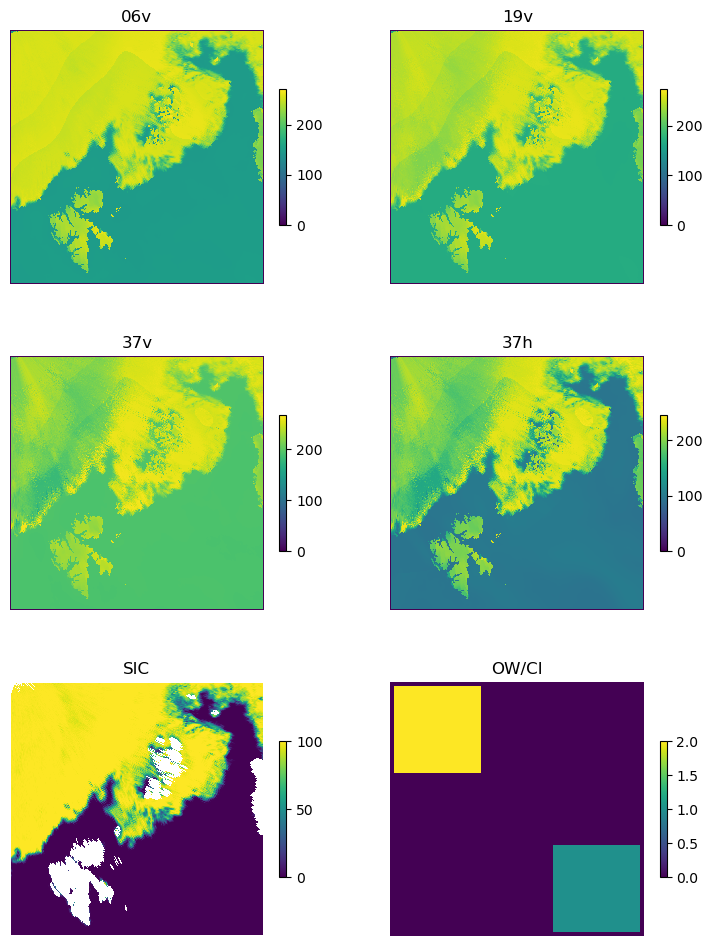

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(9,12))
c=ax[0,0].imshow(tc_tbs['tb06v'], interpolation='none', origin='lower'); ax[0,0].axis('off'); ax[0,0].set_title('06v');plt.colorbar(c,shrink=0.5)
c=ax[0,1].imshow(tc_tbs['tb19v'], interpolation='none', origin='lower'); ax[0,1].axis('off'); ax[0,1].set_title('19v');plt.colorbar(c,shrink=0.5)
c=ax[1,0].imshow(tc_tbs['tb37v'], interpolation='none', origin='lower'); ax[1,0].axis('off'); ax[1,0].set_title('37v');plt.colorbar(c,shrink=0.5)
c=ax[1,1].imshow(tc_tbs['tb37h'], interpolation='none', origin='lower'); ax[1,1].axis('off'); ax[1,1].set_title('37h');plt.colorbar(c,shrink=0.5)
c=ax[2,0].imshow(tc_sic, interpolation='none', origin='lower'); ax[2,0].axis('off'); ax[2,0].set_title('SIC');plt.colorbar(c,shrink=0.5)
c=ax[2,1].imshow(tc_owci, interpolation='none', origin='lower'); ax[2,1].axis('off'); ax[2,1].set_title('OW/CI');plt.colorbar(c,shrink=0.5)
plt.show()

In [8]:
# Load the ESA CCI RRDP samples (on which the L2 algorithm was tuned)
#    for a comparison with the signatures in the TOA files:
rrdp_dir = './sirrdp'
area = 'nh'
ow_files, ci_files = rrdp_file.find_rrdp_files(rrdp_dir, area=area, years=(2007, 2013, 2018))
channels_needed = ('tb06v', 'tb19v', 'tb37v')
rrdp_pos = rrdp_file.read_RRDP_files(area, ow_files, ci_files, channels=channels_needed)
ow_tp = tp.OWTiepoint(source='rrdp', tbs=rrdp_pos['ow'])
ci_tp = tp.CICETiepoint(source='rrdp', tbs=rrdp_pos['ci'])
ow_tp.instr = 'CIMR'
ci_tp.instr = 'CIMR'

Number of OW samples:  15955
Number of CI samples:  13441
Select every 1 OW points
Select every 10 CICE points


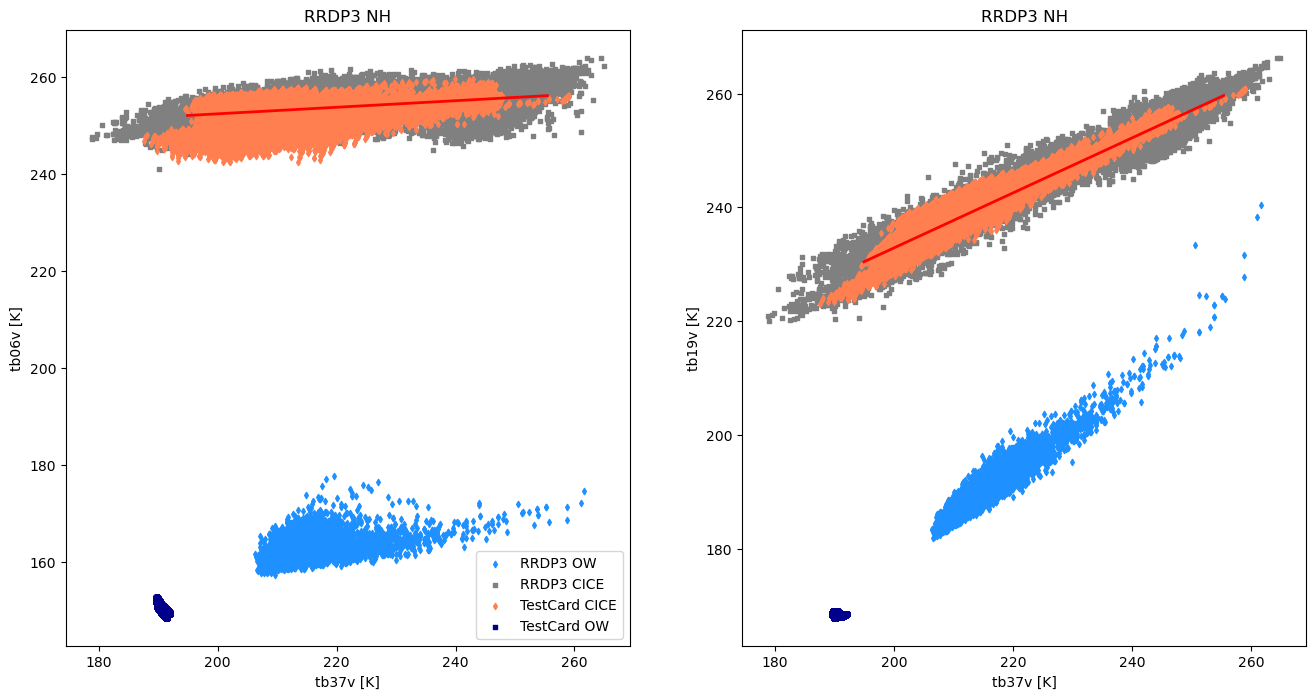

In [9]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0] = plot_2d_tiepoints(ci_tp, ow_tp, 'tb37v', 'tb06v', leg=True, ax=ax[0])
ax[0].scatter(tc_tbs['tb37v'][tc_owci==2], tc_tbs['tb06v'][tc_owci==2],
              s=10, marker='d', color='coral', label='TestCard CICE')
ax[0].scatter(tc_tbs['tb37v'][tc_owci==1], tc_tbs['tb06v'][tc_owci==1],
              s=10, marker='s', color='darkblue', label='TestCard OW')
ax[0].legend()
ax[1] = plot_2d_tiepoints(ci_tp, ow_tp, 'tb37v', 'tb19v', leg=False, ax=ax[1])
ax[1].scatter(tc_tbs['tb37v'][tc_owci==2], tc_tbs['tb19v'][tc_owci==2],
              s=10, marker='d', color='coral', )
ax[1].scatter(tc_tbs['tb37v'][tc_owci==1], tc_tbs['tb19v'][tc_owci==1],
              s=10, marker='s', color='darkblue',)
plt.show()

The diagram above visualizes that the Consolidated Ice (100% SIC) samples from the Test Card are mostly following the variability in the AMSR2 RRDP dataset (they were probably tuned from it). However, the Open Water (0% SIC) signatures in the Test Card are "colder" than those in the RRDP3 dataset and show much less variability.

The fact that the OW in the Test Card is "colder" than what the L2 algorithm was trained on translates in a negative bias of SIC over open water, which is compatible with the negative bias observed above in the map and histogram of differences.

The lack of variability indicates that this version of the SCEPS Polar Scene 1 Test Card does not include wind-induced surface roughness nor contribution from the atmosphere above the ocean. 


### Further analysis of the differences in SIC

We look in more details at the map of differences shown earlier:

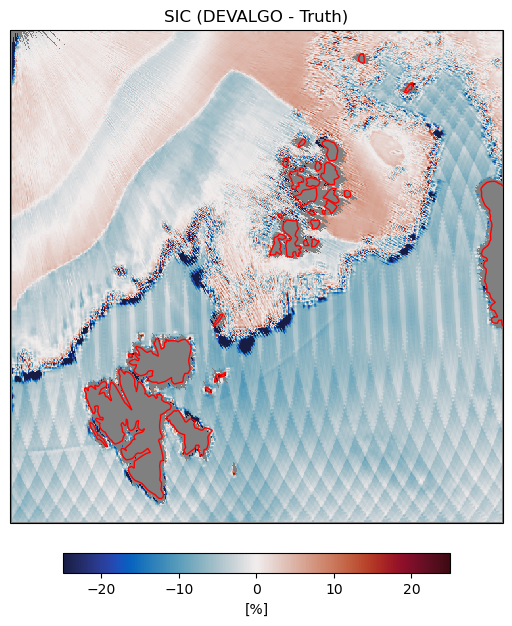

In [10]:
fig, ax = plt.subplots(figsize=(10,8), subplot_kw=dict(projection=cart_crs))
c = ax.imshow(sic_diff, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_dif,vmin=dmin,vmax=dmax, interpolation='none')
ax.coastlines(color='red')
ax.set_title('SIC (DEVALGO - Truth)',)
plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.5).set_label('[%]')
plt.show()

The following observations can be made:
* The bias is generally negative over open water, translating the difference in tuning between the RTM used in the SCEPS simulator and that of the L2 SIC algorithm. In an operational implementation, the SIC algorithm will include a dynamic tuning step to automatically calibrate the algorithm tie-points to the L1B TBs to ensure 0 bias.
* Intersecting striped patterns can be observed over open water. They are caused by the feed-depending OZA of the CIMR instrument. The feed-depending OZA is well simulated by the SCEPS instrument simulator, but is not adjusted for in the L2 SIC algorithm at this stage.
* Large bands of differences of alternating sign are observed over sea ice. These are possibly the imprint of the T0m field used to drive the simulated TBs. They are thus an artefact of the simulation, not of the L2 algorithm.
* Dark blue patches are observed along the ice edge, indicating that the SIC algorithm would have missed sea ice. Investigation and communication with the SCEPS team reveal that steps are implemented in the simulator to ensure consistency between the variables, and that this step removes some SIC (in that case) before simulating the TBs while this is not reflected in the GEO fields (the truth). This is thus an artefact of the simulation, not of the L2 algorithm.
* Some speckle can be observed in the map of differences, over the ice. Some of this speckle is also present in the maps of simulated TBs (especially KU_V and KU_H). However we cannot exclude that some of this speckle also arises (or gets amplified) by the prototype footprint-matching or gridding procedures currently implemented in the prototype L2 algorithm. Access to more advanced algorithms such as those developed in the CIMR RGB project should allow more realistic results and allow better exploiting the L1B samples.

## Algorithm Performance Assessment using Demonstration Reference Scenario

TBW